In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import math
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from IPython.display import SVG

In [2]:
class PathResolver:
    _relative_directory = '..'
    _source_directory = '{}/Src'.format(_relative_directory)
    _data_directory = '{}/Data'.format(_relative_directory)

    def GetDataFilepath(__self__, filename):
      return '{}/{}'.format(__self__._data_directory, filename)

    def GetSrcFilepath(__self__, filename):
      return '{}/{}'.format(__self__._source_directory, filename)

    def ReadDataFrameFromFilepath(__self__, filename):
      return pd.read_csv(__self__.GetDataFilepath(filename), sep=";")

In [3]:
path_resolver = PathResolver()

In [4]:
clients = path_resolver.ReadDataFrameFromFilepath('client.asc')
clients.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [5]:
class DateResolver:
    #Birthnumber is an abstraction that holds an encoded yymmdd in a specific format
    def resolve_gender_and_birthdate(__self__, date_number):
        [yy, mm, dd] = __self__._resolve_birthdate(date_number)
        
        return (__self__._resolve_gender_from_month(mm), __self__.get_date(yy, __self__._correct_month_if_necessary(mm), dd))
    
    def resolve_birthdate(__self__, date_number):
        [yy, mm, dd] = __self__._resolve_birthdate(date_number)
        
        return __self__.get_date(yy, __self__._correct_month_if_necessary(mm), dd)
    
    def _resolve_birthdate(__self__, date_number):
        pair_list = [int(x) for x in re.findall('\d{2}', str(date_number))]
        
        return [pair_list[0], pair_list[1], pair_list[2]]
        
    # If the month is larger than 50, then it is a woman (MM + 50)
    def _resolve_gender_from_month(__self__, mm):
        return 'Male' if mm < 50 else 'Female'
    
    def _correct_month_if_necessary(__self__, mm):
        return mm - 50 if mm >= 50 else mm
            
    def get_date(__self__, yy, mm, dd):
        return '19{}-{}-{}'.format(yy, mm, dd)

In [6]:
reference_analysis_date = pd.to_datetime("1999-09-15")

def get_int_years_delta(start_date, end_date):
    return len(pd.date_range(start = start_date, end = end_date,freq='D')) // 365

In [7]:
date_resolver = DateResolver()
genders_and_birth_dates = clients.birth_number.apply(date_resolver.resolve_gender_and_birthdate)
clients['gender'] = [gender for (gender, _) in genders_and_birth_dates]
clients['birth_date'] = [birth_date for (_, birth_date) in genders_and_birth_dates]
clients.birth_date = clients.birth_date.apply(pd.to_datetime)
clients['age'] = clients.birth_date.apply(lambda birth_date: get_int_years_delta(birth_date, reference_analysis_date))

clients.head()

,client_id,birth_number,district_id,gender,birth_date,age
0,1,706213,18,Female,1970-12-13,28
1,2,450204,1,Male,1945-02-04,54
2,3,406009,1,Female,1940-10-09,58
3,4,561201,5,Male,1956-12-01,42
4,5,605703,5,Female,1960-07-03,39


In [8]:
disposition = path_resolver.ReadDataFrameFromFilepath('disp.asc')
disposition.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [9]:
districts = path_resolver.ReadDataFrameFromFilepath('district.asc')
districts.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [10]:
districts.columns = ['district_id','district_name','region',"n_inhabitants",
                    "municip_less_499","municip_between_500_1999","municip_between_2000_9999",
                    "municip_more_10000", "n_cities","ratio_urban_inhab","avg_salary","unemploy_rate_95",
                    "unemploy_rate_96","n_entrepreneurs_1000_inhab","n_commited_crimes_95","n_commited_crimes_96"]
districts.head()

,district_id,district_name,region,n_inhabitants,municip_less_499,municip_between_500_1999,municip_between_2000_9999,municip_more_10000,n_cities,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [11]:
clients_dispositions = pd.merge(clients, disposition, on = 'client_id')
clients_dispositions.head()

,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type
0,1,706213,18,Female,1970-12-13,28,1,1,OWNER
1,2,450204,1,Male,1945-02-04,54,2,2,OWNER
2,3,406009,1,Female,1940-10-09,58,3,2,DISPONENT
3,4,561201,5,Male,1956-12-01,42,4,3,OWNER
4,5,605703,5,Female,1960-07-03,39,5,3,DISPONENT


In [12]:
credit_cards = path_resolver.ReadDataFrameFromFilepath('card.asc')
credit_cards.issued = pd.to_datetime(credit_cards.issued.apply(date_resolver.resolve_birthdate))
credit_cards.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15


In [13]:
class CzechTranslator:    
    _cz_to_en_dict = {
        'POPLATEK MESICNE': 'monthly', 'POPLATEK TYDNE': 'weekly', 'POPLATEK PO OBRATU': 'after_transaction',
        'PRIJEM': 'credit', 'VYDAJ': 'debit', 'VYBER': 'choice',
        'VYBER KARTOU': 'card_debit', 'VKLAD': 'cash_credit', 'VYBER': 'cash_debit', 
        'PREVOD Z UCTU': 'other_bank_credit', 'PREVOD NA UCET': 'other_bank_debit',
        'POJISTNE': 'insurance', 'SIPO': 'household', 'LEASING': 'leasing', 'UVER': 'loan',
        'DUCHOD': 'pension', 'SLUZBY': 'statement_for_payment', 'SANKC. UROK': 'sanction_negative_balance', 'UROK': 'interest_credit'
    }
    
    def translate_if_possible(__self__, word):
        if type(word) != str:
            return ''
        
        uppercase_word = str.upper(word)
        
        return __self__._cz_to_en_dict[uppercase_word] if __self__._cz_to_en_dict.get(uppercase_word) != None else word
            
czech_to_en = CzechTranslator()

In [14]:
# Translates czech words
orders = path_resolver.ReadDataFrameFromFilepath('order.asc')
orders.k_symbol = orders.k_symbol.apply(czech_to_en.translate_if_possible)
orders.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,household
1,29402,2,ST,89597016,3372.7,loan
2,29403,2,QR,13943797,7266.0,household
3,29404,3,WX,83084338,1135.0,household
4,29405,3,CD,24485939,327.0,


In [15]:
# Translates A, B, C and D to human readable fields
loans_status_lookup = {'A': 'finished_ok', 'B': 'finished_with_default', 'C': 'running_ok', 'D': 'running_in_debt'}
loans = path_resolver.ReadDataFrameFromFilepath('loan.asc')
loans.date = pd.to_datetime(loans.date.apply(date_resolver.resolve_birthdate))
loans.status = [loans_status_lookup[status] for status in loans.status]
loans.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,finished_with_default
1,5316,1801,1993-07-11,165960,36,4610.0,finished_ok
2,6863,9188,1993-07-28,127080,60,2118.0,finished_ok
3,5325,1843,1993-08-03,105804,36,2939.0,finished_ok
4,7240,11013,1993-09-06,274740,60,4579.0,finished_ok


In [16]:
accounts = path_resolver.ReadDataFrameFromFilepath('account.asc')
accounts.date = pd.to_datetime(accounts.date.apply(date_resolver.resolve_birthdate))
accounts.frequency = accounts.frequency.apply(czech_to_en.translate_if_possible)
print(accounts.frequency.value_counts())
accounts.head()

monthly              4167
weekly                240
after_transaction      93
Name: frequency, dtype: int64


,account_id,district_id,frequency,date
0,576,55,monthly,1993-01-01
1,3818,74,monthly,1993-01-01
2,704,55,monthly,1993-01-01
3,2378,16,monthly,1993-01-01
4,2632,24,monthly,1993-01-02


In [17]:
transactions = pd.read_csv(path_resolver.GetDataFilepath('trans.asc'), sep=";", dtype = {'operation': str})
transactions.date = pd.to_datetime(transactions.date.apply(date_resolver.resolve_birthdate))
transactions.type = transactions.type.apply(czech_to_en.translate_if_possible)
print(transactions.type.value_counts())
print("==============================")
transactions.operation = transactions.operation.apply(czech_to_en.translate_if_possible)
print(transactions.operation.value_counts())
transactions.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


debit         634571
credit        405083
cash_debit     16666
Name: type, dtype: int64
cash_debit           434918
other_bank_debit     208283
                     183114
cash_credit          156743
other_bank_credit     65226
card_debit             8036
Name: operation, dtype: int64


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,credit,cash_credit,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,credit,cash_credit,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,credit,cash_credit,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,credit,cash_credit,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,credit,cash_credit,400.0,400.0,NaN,NaN,NaN


In [64]:
clients_cards = pd.merge(clients_dispositions, credit_cards, on = 'disp_id', suffi)
print(clients_cards.shape)
clients_cards.head()

(892, 12)


,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type_x,card_id,type_y,issued
0,9,351016,60,Male,1935-10-16,63,9,7,OWNER,1,gold,1998-10-16
1,19,421228,47,Male,1942-12-28,56,19,14,OWNER,2,classic,1998-03-13
2,41,680827,22,Male,1968-08-27,31,41,33,OWNER,3,gold,1995-09-03
3,42,350817,68,Male,1935-08-17,64,42,34,OWNER,4,classic,1998-11-26
4,51,796202,36,Female,1979-12-02,19,51,43,OWNER,5,junior,1995-04-24


In [28]:
clients_districts = pd.merge(clients_dispositions, districts, on = 'district_id')
clients_districts.loc[clients_districts['unemploy_rate_95'] == '?', 'unemploy_rate_95'] = np.average(clients_districts['unemploy_rate_95'] != '?')
clients_districts.loc[clients_districts['n_commited_crimes_95'] == '?', 'n_commited_crimes_95'] = np.average(clients_districts['n_commited_crimes_95'] != '?')
clients_districts.n_commited_crimes_95 = clients_districts.n_commited_crimes_95.astype(dtype = 'int64')
clients_districts.unemploy_rate_95 = clients_districts.unemploy_rate_95.astype(dtype = 'float64')

clients_districts.head()

,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type,district_name,...,municip_between_2000_9999,municip_more_10000,n_cities,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96
0,1,706213,18,Female,1970-12-13,28,1,1,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
1,420,780313,18,Male,1978-03-13,21,420,343,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
2,499,355708,18,Female,1935-07-08,64,499,413,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
3,519,800413,18,Male,1980-04-13,19,519,431,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
4,682,791021,18,Male,1979-10-21,19,682,568,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910


In [19]:
accounts_districts = pd.merge(accounts, districts, on = 'district_id')
accounts_districts.head()

,account_id,district_id,frequency,date,district_name,region,n_inhabitants,municip_less_499,municip_between_500_1999,municip_between_2000_9999,municip_more_10000,n_cities,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96
0,576,55,monthly,1993-01-01,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
1,704,55,monthly,1993-01-01,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
2,192,55,monthly,1993-01-08,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
3,10364,55,monthly,1993-01-17,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
4,497,55,monthly,1993-04-15,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894


In [20]:
clients_accounts = pd.merge(clients_dispositions, accounts, on = 'account_id', suffixes = ('_client', '_account'))
clients_accounts.head()

,client_id,birth_number,district_id_client,gender,birth_date,age,disp_id,account_id,type,district_id_account,frequency,date
0,1,706213,18,Female,1970-12-13,28,1,1,OWNER,18,monthly,1995-03-24
1,2,450204,1,Male,1945-02-04,54,2,2,OWNER,1,monthly,1993-02-26
2,3,406009,1,Female,1940-10-09,58,3,2,DISPONENT,1,monthly,1993-02-26
3,4,561201,5,Male,1956-12-01,42,4,3,OWNER,5,monthly,1997-07-07
4,5,605703,5,Female,1960-07-03,39,5,3,DISPONENT,5,monthly,1997-07-07


In [21]:
clients_districts_cards = pd.merge(clients_districts, credit_cards, on = 'disp_id', suffixes=('_client', '_card'))
clients_districts_cards.loc[clients_districts_cards['unemploy_rate_95'] == '?', 'unemploy_rate_95'] = np.average(clients_districts_cards['unemploy_rate_95'] != '?')
clients_districts_cards.loc[clients_districts_cards['n_commited_crimes_95'] == '?', 'n_commited_crimes_95'] = np.average(clients_districts_cards['n_commited_crimes_95'] != '?')
clients_districts_cards.n_commited_crimes_95 = clients_districts_cards.n_commited_crimes_95.astype(dtype = 'int64')
clients_districts_cards.unemploy_rate_95 = clients_districts_cards.unemploy_rate_95.astype(dtype = 'float64')

print(clients_districts_cards.info())
clients_districts_cards.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 0 to 891
Data columns (total 27 columns):
client_id                     892 non-null int64
birth_number                  892 non-null int64
district_id                   892 non-null int64
gender                        892 non-null object
birth_date                    892 non-null datetime64[ns]
age                           892 non-null int64
disp_id                       892 non-null int64
account_id                    892 non-null int64
type_client                   892 non-null object
district_name                 892 non-null object
region                        892 non-null object
n_inhabitants                 892 non-null int64
municip_less_499              892 non-null int64
municip_between_500_1999      892 non-null int64
municip_between_2000_9999     892 non-null int64
municip_more_10000            892 non-null int64
n_cities                      892 non-null int64
ratio_urban_inhab             892 non-null float6

,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type_client,district_name,...,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96,card_id,type_card,issued
0,519,800413,18,Male,1980-04-13,19,519,431,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,95,junior,1998-08-01
1,1140,460224,18,Male,1946-02-24,53,1140,945,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,187,classic,1997-09-07
2,1169,415124,18,Female,1941-01-24,58,1169,970,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,192,classic,1998-06-08
3,1382,796123,18,Female,1979-11-23,19,1382,1149,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,228,junior,1998-03-15
4,1883,616027,18,Female,1961-10-27,37,1883,1552,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,297,classic,1997-06-15


In [22]:
clients_accounts_loans = pd.merge(clients_accounts, loans, on = 'account_id', suffixes = ('_client', '_loan'))
clients_accounts_loans.head()

,client_id,birth_number,district_id_client,gender,birth_date,age,disp_id,account_id,type,district_id_account,frequency,date_client,loan_id,date_loan,amount,duration,payments,status
0,2,450204,1,Male,1945-02-04,54,2,2,OWNER,1,monthly,1993-02-26,4959,1994-01-05,80952,24,3373.0,finished_ok
1,3,406009,1,Female,1940-10-09,58,3,2,DISPONENT,1,monthly,1993-02-26,4959,1994-01-05,80952,24,3373.0,finished_ok
2,25,395423,21,Female,1939-04-23,60,25,19,OWNER,21,monthly,1995-04-07,4961,1996-04-29,30276,12,2523.0,finished_with_default
3,31,620209,68,Male,1962-02-09,37,31,25,OWNER,68,monthly,1996-07-28,4962,1997-12-08,30276,12,2523.0,finished_ok
4,45,520826,20,Male,1952-08-26,47,45,37,OWNER,20,monthly,1997-08-18,4967,1998-10-14,318480,60,5308.0,running_in_debt


In [118]:
def is_different(row, first_column, second_column):
    return 1 if row[first_column] != row[second_column] else 0

def get_quantile_index(value, quantiles, quantile_list):
    i = 1
    
    for quantile in quantile_list:
        if quantiles[quantile] >= value:
            break
        else:
            i += 1
            
    return i

def create_quantile_distribution(df, column, start, increment):
    quantile_list = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
    value = start
    
    df[column].fillna(np.average(df[column].notna()), inplace = True)
        
    quantiles = df[column].quantile(quantile_list)
    
    return df[column].apply(lambda x: get_quantile_index(x, quantiles, quantile_list[1:4]) * increment + start).astype(dtype = 'int64')

def create_negative_quantile_distribution(df, column):
    return create_quantile_distribution(df, column, 4, -1)

def create_positive_quantile_distribution(df, column):
    return create_quantile_distribution(df, column, 0, 1)
    
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

clients_rating = clients_dispositions[['client_id', 'gender', 'age', 'account_id']]
clients_rating.loc[:, 'district_id_client'] = clients_accounts.district_id_client
clients_rating.loc[:, 'district_id_account'] = clients_accounts.district_id_account

clients_rating.loc[:, 'district_id_diff'] = clients_rating.apply(lambda row: is_different(row, 'district_id_client', 'district_id_account'), axis = 1)
clients_rating.loc[:, 'dis_avg_salary'] = create_positive_quantile_distribution(clients_districts, 'avg_salary')
clients_rating.loc[:, 'dis_unemp_rate_95'] = create_positive_quantile_distribution(clients_districts, 'unemploy_rate_95')
clients_rating.loc[:, 'dis_unemp_rate_96'] = create_positive_quantile_distribution(clients_districts, 'unemploy_rate_96')
clients_rating.loc[:, 'dis_commit_crimes_95'] = create_positive_quantile_distribution(clients_districts, 'n_commited_crimes_95')
clients_rating.loc[:, 'dis_commit_crimes_96'] = create_positive_quantile_distribution(clients_districts, 'n_commited_crimes_96')
clients_rating.loc[:, 'year_account'] = clients_accounts.date.apply(lambda date: get_int_years_delta(date, reference_analysis_date))
# client type - Owner - 2, DISPONENT - 1
clients_rating.loc[:, 'client_type'] = clients_districts['type'].astype(dtype = 'category').cat.codes + 1

card_score_lookup = [2, 3, 1, 0] # nan gets converted to - 1
clients_rating = clients_rating.merge(clients_districts_cards[['client_id', 'type_card', 'issued']], how = 'left', on = 'client_id')
clients_rating.loc[:, 'type_card'] = clients_rating.type_card.astype(dtype='category').cat.codes.apply(lambda x: card_score_lookup[x]).astype(dtype = 'int64')
clients_rating.loc[:, 'year_card'] = 0
cards_years_mask = clients_rating.issued.notna()
clients_rating.loc[cards_years_mask, 'year_card'] = clients_rating.issued[cards_years_mask].apply(lambda date: get_int_years_delta(date, reference_analysis_date)).astype(dtype = 'int64')
clients_rating.drop('issued', axis = 1, inplace = True)

clients_rating = clients_rating.merge(clients_accounts_loans[['client_id', 'frequency', 'status']], how = 'left', on = 'client_id')
frequency_lookup = [1, 2, 3, 0] # nan gets converted to - 1
clients_rating.loc[:, 'frequency'] = clients_rating.frequency.astype(dtype='category').cat.codes.apply(lambda x: frequency_lookup[x]).astype(dtype = 'int64')
status_lookup = [4, -4, -4, 4, 0] # nan gets converted to - 1
clients_rating.loc[:, 'status'] = clients_rating.status.astype(dtype='category').cat.codes.apply(lambda x: status_lookup[x]).astype(dtype = 'int64')

clients_rating.loc[:, 'year_loan'] = clients_accounts_loans.date_loan.apply(lambda date: get_int_years_delta(date, reference_analysis_date))
clients_rating.year_loan.fillna(0, inplace = True)
clients_rating.loc[:, 'duration_loan'] = clients_accounts_loans.duration
clients_rating.duration_loan.fillna(0, inplace = True)
clients_rating.loc[:, 'mth_to_pay_loan'] = clients_rating.apply(lambda row: row['duration_loan'] - row['year_loan'] * 12, axis = 1)

clients_rating.loc[:, 'sum_score'] = clients_rating.apply(lambda row: max(row['district_id_diff':'mth_to_pay_loan'].sum(), 0), axis = 1)
sum_score_discrete_labels = ['bad', 'average', 'ok', 'good'] 
clients_rating.loc[:, 'sum_score_label'] = pd.qcut(clients_rating.sum_score, 4, labels = sum_score_discrete_labels)
clients_rating.loc[:, 'gender'] = clients_rating.gender.astype(dtype = 'category').cat.codes
clients_rating.info()
clients_rating.head()

/home/home/andre/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/home/andre/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 23 columns):
client_id               5369 non-null int64
gender                  5369 non-null int8
age                     5369 non-null int64
account_id              5369 non-null int64
district_id_client      5369 non-null int64
district_id_account     5369 non-null int64
district_id_diff        5369 non-null int64
dis_avg_salary          5369 non-null int64
dis_unemp_rate_95       5369 non-null int64
dis_unemp_rate_96       5369 non-null int64
dis_commit_crimes_95    5369 non-null int64
dis_commit_crimes_96    5369 non-null int64
year_account            5369 non-null int64
client_type             5369 non-null int8
type_card               5369 non-null int64
year_card               5369 non-null int64
frequency               5369 non-null int64
status                  5369 non-null int64
year_loan               5369 non-null float64
duration_loan           5369 non-null float64
mth_to_pay_

,client_id,gender,age,account_id,district_id_client,district_id_account,district_id_diff,dis_avg_salary,dis_unemp_rate_95,dis_unemp_rate_96,...,client_type,type_card,year_card,frequency,status,year_loan,duration_loan,mth_to_pay_loan,sum_score,sum_score_label
0,1,0,28,1,18,18,0,2,3,2,...,2,0,0,0,0,5.0,24.0,-36.0,8.0,bad
1,2,1,54,2,1,1,0,2,3,2,...,2,0,0,2,4,5.0,24.0,-36.0,16.0,bad
2,3,0,58,2,1,1,0,2,3,2,...,2,0,0,2,4,3.0,12.0,-24.0,14.0,bad
3,4,1,42,3,5,5,0,2,3,2,...,2,0,0,0,0,1.0,12.0,0.0,26.0,good
4,5,0,39,3,5,5,0,2,3,2,...,2,0,0,0,0,0.0,60.0,60.0,133.0,good


In [110]:
clients_rating.sum_score_label.value_counts()

bad        1456
average    1431
good       1311
ok         1171
Name: sum_score_label, dtype: int64

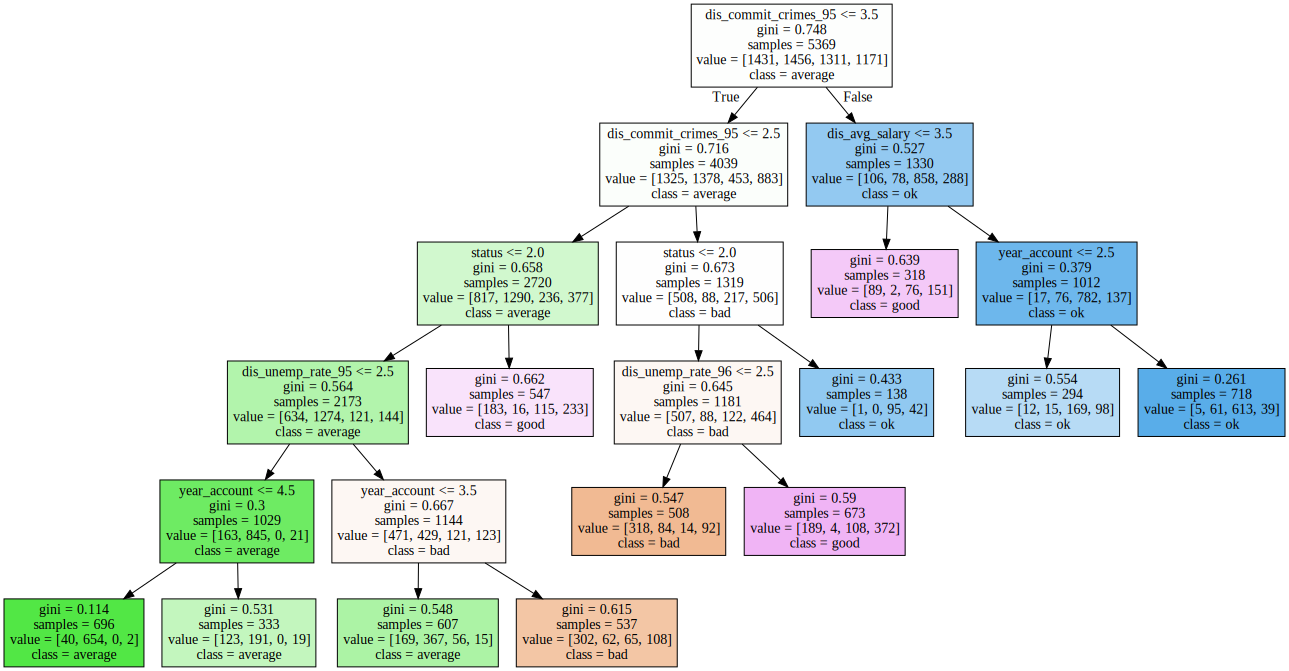

In [121]:
# Still not using python processed data
#arquivo = pd.read_csv("banco.csv", sep = ";")

#clients_rating.fillna(0, inplace = True)

y = clients_rating["sum_score_label"]
feature_names = ["gender", "age", "dis_avg_salary", "dis_unemp_rate_95", "dis_unemp_rate_96",
        "dis_commit_crimes_95", "dis_commit_crimes_96", "client_type", "type_card", "year_card", "frequency", 
        "year_account", "status"]
X = clients_rating[feature_names]

dt = DecisionTreeClassifier(min_samples_split=1000, random_state=99)
dt.fit(X, y)

graph2 = Source(export_graphviz(dt, out_file=None
   , feature_names=feature_names, class_names = sum_score_discrete_labels
   , filled = True))

display(SVG(graph2.pipe(format='svg')))